In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [34]:

# --- 1. CONFIGURATION AND HYPERPARAMETERS ---
class Config:
    """Stores all configuration settings."""
    # Updated to match the user's project structure
    DATA_ROOT = './MNIST-Data' 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    EPOCHS = 20
    MOMENTUM = 0.9
    MODEL_SAVE_PATH = 'best_mnist_cnn.pth'
    PATIENCE = 2 # Number of epochs to wait for improvement before stopping

print(f"Configuration loaded. Using device: {Config.DEVICE}")

Configuration loaded. Using device: cpu


In [35]:
# --- 2. DATASET AND DATALOADER ---
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize images using standard MNIST mean and std
    transforms.Normalize((0.1307,), (0.3081,)) 
])

# Load the MNIST datasets
print(f"Loading MNIST datasets from {Config.DATA_ROOT}...")
# PyTorch handles downloading and parsing the raw IDX files.
train_dataset = MNIST(root=Config.DATA_ROOT, train=True, download=True, transform=transform)
test_dataset = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 0
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count() or 0
)
print(f"Data loading complete. Using device: {Config.DEVICE}")

Loading MNIST datasets from ./MNIST-Data...
Data loading complete. Using device: cpu


In [ ]:
# --- 3. NN.MODULE MODEL (Simple CNN) ---
class SimpleCNN(nn.Module):
    """Convolutional Neural Network (CNN) for MNIST classification."""
    def __init__(self):
        super().__init__()
        # Layer 1: Conv (1->16 channels, 28x28 output), ReLU, Pool (16x14x14 output)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Conv (16->32 channels, 14x14 output), ReLU, Pool (32x7x7 output)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Layer 3: Fully Connected (32*7*7 inputs, 125 outputs)
        self.fc1 = nn.Linear(32 * 7 * 7, 125)

        # Layer 4: Fully Connected (125 inputs, 10 outputs)
        self.fc2 = nn.Linear(125, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Flatten for the linear layer
        x = x.view(-1, 32 * 7 * 7) 
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss Function, and Optimizer
model = SimpleCNN().to(Config.DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), 
    lr=Config.LEARNING_RATE, 
    momentum=Config.MOMENTUM
)

print("Model, Loss, and Optimizer initialized.")
print(model)


Model, Loss, and Optimizer initialized.
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=10, bias=True)
)


In [37]:
# --- 4. MANUAL TRAINING LOOP FUNCTION ---
def train_model(model, device, train_loader, criterion, optimizer, epoch, train_losses):
    """Performs one epoch of training."""
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad() 

        # 2. Forward pass
        output = model(data) 

        # 3. Calculate Loss
        loss = criterion(output, target)

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'====> Epoch: {epoch} Average train loss: {epoch_loss:.4f}')


In [38]:
# --- 5. EVALUATION ACCURACY FUNCTION (Validation) ---
def evaluate_model(model, device, test_loader, criterion, test_losses):
    """Evaluates the model on the test set (used as validation for monitoring)."""
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item() 
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) / Config.BATCH_SIZE
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set (Validation): Avg Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy

In [39]:
# --- 6. MAIN EXECUTION WITH CHECKPOINTING AND EARLY STOPPING ---
def run_training_pipeline():
    """Runs the full training and evaluation process with early stopping."""
    train_losses = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    epochs_no_improve = 0
    
    print(f"Starting training for max {Config.EPOCHS} epochs with Patience={Config.PATIENCE}...")

    for epoch in range(1, Config.EPOCHS + 1):
        train_model(model, Config.DEVICE, train_loader, criterion, optimizer, epoch, train_losses)
        accuracy = evaluate_model(model, Config.DEVICE, test_loader, criterion, test_losses)
        test_accuracies.append(accuracy)

        # --- CHECKPOINTING & EARLY STOPPING LOGIC ---
        if accuracy > best_accuracy:
            # Improvement found: Reset counter and save the model
            best_accuracy = accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            print(f"--> Checkpoint saved! New best accuracy: {best_accuracy:.2f}%")
        else:
            # No improvement: Increment counter
            epochs_no_improve += 1
            print(f"Improvement counter: {epochs_no_improve}/{Config.PATIENCE}")

        if epochs_no_improve >= Config.PATIENCE:
            print(f"Early stopping triggered after {Config.PATIENCE} epochs without improvement.")
            break

    print("--- Training Summary ---")
    print(f"Best Test Accuracy Achieved: {best_accuracy:.2f}% (Model saved to {Config.MODEL_SAVE_PATH})")

    # Load the best model weights for final evaluation if early stopping occurred
    if os.path.exists(Config.MODEL_SAVE_PATH):
        model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
        print("Loaded best model weights for final summary.")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    # The test loss is used as the validation metric
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss') 
    plt.title('Loss Curves Over Epochs (with Early Stopping)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Starting training for max 20 epochs with Patience=2...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316158
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.047130
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.838242
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.477042
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.307425
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.369468
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.367980
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.275175
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.321149
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.299521
====> Epoch: 1 Average train loss: 0.6845

Test set (Validation): Avg Loss: 0.2339, Accuracy: 92.84%
--> Checkpoint saved! New best accuracy: 92.84%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.356525
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.349535
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.199390
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.166642
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.247416
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.206411
Train Ep

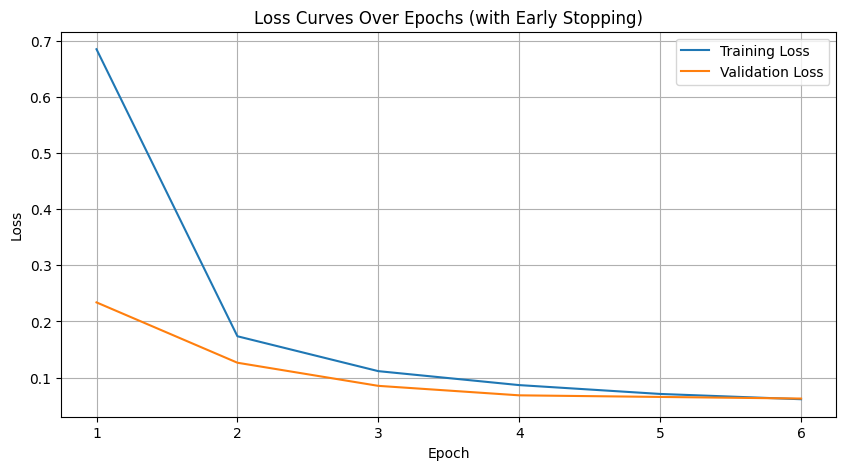

In [40]:
run_training_pipeline()